In [63]:
%load_ext autoreload
%autoreload 2

import transformers
import tokenizers
import gc
import torch
import os
import pandas as pd
import numpy as np
import re
import math

from pathlib import Path
import bertviz
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import lime
from lime.lime_text import LimeTextExplainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Model:
* 12 layers
* 12 attention heads
* 768 hidden states

In [2]:
os.chdir("/media/koekiemonster/DATA-FAST/text_data/")

In [3]:
torch.cuda.is_available(), torch.cuda.is_initialized()

(True, False)

In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, RobertaTokenizer, RobertaForMaskedLM

model_name = 'medroberta_journals_ARGUS_nvvc_IBD_RA' # belabbert #medroberta

tokenizer = AutoTokenizer.from_pretrained("word_vectors_and_language_models/dutch/Medical/languagemodels/"+model_name)
model_mlm = AutoModelForMaskedLM.from_pretrained("word_vectors_and_language_models/dutch/Medical/languagemodels/"+model_name)  

In [5]:
test_input = tokenizer("De <mask> was nauwelijks aanspreekbaar. <mask> zag er grauw uit. Hij <mask> de inspanningstest <mask> <mask> doorstaan. De <mask> heeft last van <mask> en <mask>.", return_tensors='pt')
#test_input.to(device='cuda:0')
output = model_mlm.forward(**test_input, output_attentions=True )

odds = torch.exp(output.logits)
proba = odds/(1+odds)
word_idcs = torch.argmax(proba[0], axis=1)
tokens = tokenizer.convert_ids_to_tokens(word_idcs)
print(" ".join(tokens))

Ġnog De Ġheer Ġwas Ġnauwelijks Ġaanspreekbaar . ĠHij Ġzag Ġer Ġgrauw Ġuit . ĠHij Ġheeft Ġde Ġinspanningstest Ġniet Ġgoed Ġdoorstaan . ĠDe Ġheer Ġheeft Ġlast Ġvan Ġduizeligheid Ġen Ġkortademigheid . ĠDhr


In [6]:
tokenizer.convert_ids_to_tokens(torch.topk(proba[0], axis=1, k=20).indices[7])

['ĠHij',
 'ĠDeze',
 'ĠPatient',
 'ĠMeneer',
 'ĠWel',
 'ĠIk',
 'ĠDhr',
 'ĠTong',
 'ĠZij',
 'ĠEchtgenote',
 'ĠAlles',
 'ĠPericard',
 'ĠHet',
 'ĠElektrocardiogram',
 'ĠLater',
 'ĠRechter',
 'ĠHoofd',
 'ĠDit',
 'ĠSupervisor',
 'ĠOok']

In [7]:
for i in range(len(output.attentions)):
    out =+ output.attentions[i].detach().numpy()/len(output.attentions)

<AxesSubplot:>

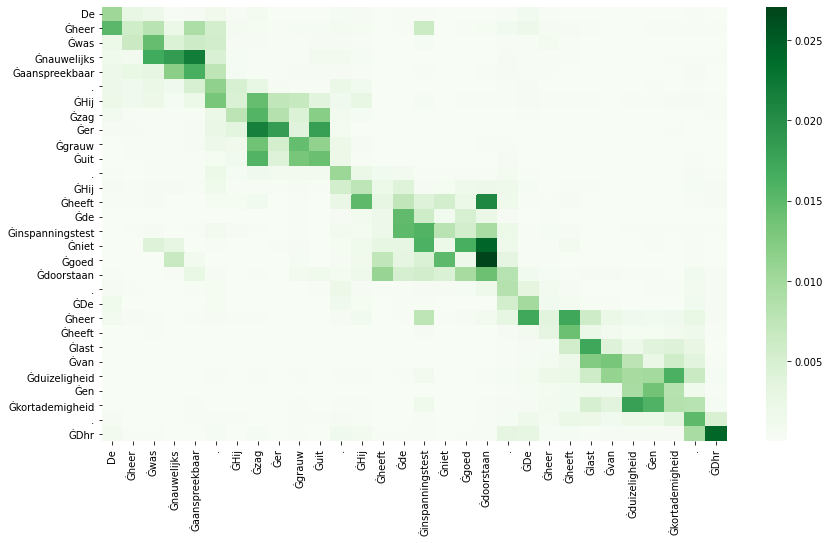

In [8]:
mean_attention = out[0].mean(axis=0)
#mean_attention = output.attentions[0][0].abs().detach().numpy().mean(axis=0)

plt.figure(figsize=(14,8))
sns.heatmap(pd.DataFrame(data=mean_attention[1:,1:], columns=tokens[1:], index=tokens[1:]), cmap='Greens')

Use https://captum.ai/tutorials/ to interpret the entity classification

In [9]:
from transformers import AutoModelForTokenClassification, AutoModelForSequenceClassification

In [10]:
model_ner = AutoModelForTokenClassification.from_pretrained("word_vectors_and_language_models/dutch/Medical/languagemodels/fine_tuned_token_classification_MedRoBERTa_3_2_512")

In [11]:
torch.nn.functional.softmax(output.logits[0]).shape

<ipython-input-11-f957bb4283be>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(output.logits[0]).shape


torch.Size([31, 52000])

In [12]:
output = model_ner.forward(**test_input, output_attentions=True, output_hidden_states=True)

target_map = {0: 'B-Negated', 1:'B-NotNegated',2:'I-Negated',3:'I-NotNegated'}
proba = torch.nn.functional.softmax(output.logits[0]).detach().numpy()
#odds = torch.exp(output.logits)
#proba = (odds/(1+odds))[0].detach().numpy()

<ipython-input-12-4b698b849f15>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = torch.nn.functional.softmax(output.logits[0]).detach().numpy()


In [13]:
def predictor_token(tokenid=0):
    def _predictor_token(texts):
        res = np.zeros((np.max([1,len(texts)]),2))
        for idx, text in enumerate(texts):
            tokenized_text = tokenizer(text, return_tensors='pt', padding=True)
            output = model_ner.forward(**tokenized_text, output_attentions=True, output_hidden_states=True)
            proba = torch.nn.functional.softmax(output.logits[0]).detach().numpy()
            probas = np.vstack([proba[:,0]+proba[:,2], proba[:,1]+proba[:,3]]).T
            res[idx,:] = probas[tokenid,:]
        return res
    return _predictor_token

def predictor(text):
    tokenized_text = tokenizer(text, return_tensors='pt', padding=True)
    output = model_ner.forward(**tokenized_text, output_attentions=True, output_hidden_states=True)
    proba = torch.nn.functional.softmax(output.logits[0]).detach().numpy()
    probas = np.vstack([proba[:,0]+proba[:,2], proba[:,1]+proba[:,3]]).T
    return probas

def get_tokens(text):
    tokenized_text = tokenizer(text, return_tensors='pt', padding=True)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0])
    return tokens

In [26]:
input_string = "De patient heeft geen myocarditis. Er is wel stenose in de aderen geconstateerd."
tokens = get_tokens(input_string)
proba = predictor(input_string)

negation_probas = pd.DataFrame(data=proba, index=[str(idx)+" "+t for idx,t in enumerate(tokens)], 
                               columns=['Negated', 'NotNegated'])

cm = sns.color_palette("rocket_r", as_cmap=True)
negation_probas.style.background_gradient(cmap=cm)

<ipython-input-13-39616ed907ef>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = torch.nn.functional.softmax(output.logits[0]).detach().numpy()


,Negated,NotNegated
0,0.648235,0.351765
1 De,0.273208,0.726792
2 Ġpatient,0.409033,0.590967
3 Ġheeft,0.703296,0.296704
4 Ġgeen,0.953247,0.046753
5 Ġmyocarditis,0.999742,0.000258
6 .,0.999312,0.000688
7 ĠEr,0.486802,0.513198
8 Ġis,0.461240,0.538760
9 Ġwel,0.051966,0.948034


In [15]:
import spacy
from spacy import displacy 
from medcat.cat import CAT
from medcat.vocab import Vocab
from medcat.cdb import CDB
from medcat.config import Config

cdb_file = '/media/koekiemonster/DATA-FAST/text_data/medcat/output/cdb.dat'
vocab_file = '/media/koekiemonster/DATA-FAST/text_data/medcat/output/vocab.dat'
config_file = '/media/koekiemonster/DATA-FAST/text_data/medcat/input/medcat_config.txt'

config = Config()
config.parse_config_file(config_file)
vocab = Vocab.load(vocab_file)
cdb = CDB.load(cdb_file)

In [16]:
nlp = spacy.load("nl_core_news_lg") # , disable=['tok2vec'], exclude=['tok2vec'])

In [17]:
cat = CAT(cdb=cdb, vocab=vocab, config=config)

In [36]:
doc = cat(input_string)
# Print detected entities
print(doc.ents)

# Extract the document entities directly
for d in doc.ents:
    print(f'Detected name: {d._.detected_name}')
    print(f'CUI: {d._.cui}\n')
    
displacy.render(doc, style='ent', jupyter=True)

(myocarditis, stenose, aderen)
Detected name: myocarditi
CUI: C0027059

Detected name: stenose
CUI: C1261287

Detected name: ader
CUI: C0042449



In [70]:
doc = nlp(input_string)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 120, 'compact': False, 'bg': 'white'})

svg = displacy.render(doc, style='dep', jupyter=False, options={'distance': 120, 'compact': False, 'bg': 'white'})
output_path = Path("sentence.svg")
output_path.open("w", encoding="utf-8").write(svg)

9927

In [19]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler

In [20]:
sampler = MaskingTextSampler(
                replacement="UNK",
                max_replace=0.7,
                token_pattern=None,
                bow=False
                )

In [21]:
samples, _ = sampler.sample_near(input_string, n_samples=4)

In [22]:
te = TextExplainer(
                sampler=sampler,
                position_dependent=True,
                random_state=42,
                n_samples=100,
                )

In [23]:
te.fit(input_string, predictor_token(tokenid=5))

<ipython-input-13-39616ed907ef>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = torch.nn.functional.softmax(output.logits[0]).detach().numpy()


TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',
                                random_state=RandomState(MT19937) at 0x7F131E448540),
              n_samples=100, position_dependent=True, random_state=42,
              sampler=MaskingTextSampler(bow=False, max_replace=0.7,
                                         replacement='UNK',
                                         token_pattern='(?u)\\b\\w+\\b'),
              token_pattern='(?u)\\b\\w+\\b',
              vec=SingleDocumentVectorizer(token_pattern='(?u)\\b\\w+\\b'))

In [24]:
explain = te.explain_prediction(
            target_names=['Negated', 'Not_negated'])

In [25]:
explain

Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x7F131E448940)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Negated', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[3] geen', weight=6.207284314144327, std=None, value=1.0), FeatureWeight(feature='[2] heeft', weight=2.0672706870333872, std=None, value=1.0), FeatureWeight(feature='[0] De', weight=1.8992216883978794, std=None, value=1.0), FeatureWeight(feature='[5] Er', weight=0.8332744955180991, std=None, value=1.0), FeatureWeight(feature='[12] geconstateerd', weight=0.3866762700963125, std=None, value=1.0), FeatureWeight(feature='[1] patient', weight=0.36665991205840487, std=None, value=1.0), FeatureWeight(feature='[9] van', weight=0.3233139280755361, std=None, value=1.0), FeatureWeight(feature='[7] wel', weight=0.21389266182452527, std=None, value=1.0), FeatureWeight(feature='[10] de', weight=0.11977153627864615, std=None, value=1.0), FeatureWeight(feature='[6] is', weight=0.04453091655049721, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-7.666898641213383, std=None, value=1.0), FeatureWeight(feature='[11] aderen', weight=-0.6245797745595577, std=None, value=1.0), FeatureWeight(feature='[4] myocarditis', weight=-0.15708029420404432, std=None, value=1.0), FeatureWeight(feature='[8] stenosering', weight=-0.10087151798293152, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9804006743992835, score=-3.912466182017699, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='De patient heeft geen myocarditis. Er is wel stenosering van de aderen geconstateerd.', spans=[('De', [(0, 2)], 1.8992216883978794), ('patient', [(3, 10)], 0.36665991205840487), ('heeft', [(11, 16)], 2.0672706870333872), ('geen', [(17, 21)], 6.207284314144327), ('myocarditis', [(22, 33)], -0.15708029420404432), ('Er', [(35, 37)], 0.8332744955180991), ('is', [(38, 40)], 0.04453091655049721), ('wel', [(41, 44)], 0.21389266182452527), ('stenosering', [(45, 56)], -0.10087151798293152), ('van', [(57, 60)], 0.3233139280755361), ('de', [(61, 63)], 0.11977153627864615), ('aderen', [(64, 70)], -0.6245797745595577), ('geconstateerd', [(71, 84)], 0.3866762700963125)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=11.579364823231082, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-7.666898641213383, std=None, value=1.0)], pos_remaining=0, neg_remaining=0)), heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)